In [1]:
from __future__ import division

from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from math import inf, sqrt
from skimage import data, color
from skimage.transform import rescale, resize
import warnings
warnings.filterwarnings('ignore')

In [2]:
class SinglePointFM:
    
    def __init__(self, n, origin_point, W):
        """
            Class variables: I, D, S
        """
        
        self.n = n
        self.start_point = origin_point
        self.W = W
        
        self.neigh = np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
        
        # Build I the initial stack
        x0 = [self.start_point[1], self.start_point[0]]
        self.I = [self.sub2ind1(x0)]
        
        # Initial distance to x0
        D = np.ones((self.n, self.n)) + inf
        u = self.ind2sub1(self.I)
        D[u[0], u[1]] = 0
        self.D = D
        
        # To visit or not
        S = np.zeros((self.n, self.n))
        S[u[0], u[1]] = 1
        self.S = S
    
    def boundary(self, x):
        return np.mod(x, self.n)
        
    def sub2ind1(self, u):
        return int(u[0]*self.n + u[1])
    
    def ind2sub1(self, k):
        return [int( (k-np.fmod(k,self.n))/self.n ), np.fmod(k,self.n)]
    
    def Neigh(self, k, i):
        neigh_coord = self.boundary(self.ind2sub1(k) + self.neigh[:,i])
        if self.is_border(neigh_coord):
            return None
        else:
            return self.sub2ind1(neigh_coord)

    def is_border(self, pixel_coord):
        return bool(np.sum(pixel_coord==0) + np.sum(pixel_coord==self.n))

    def extract(self, x, I):
        return x[I]

    def extract1d(self, x, I):
        if I is None:
            return inf
        else:
            return self.extract(x.flatten(), I)
    
    def DNeigh(self, D, k, j):
        return self.extract1d(D, self.Neigh(j, k))
    
    def forward(self):
        
        if not self.I:
            return
        
        j = np.argsort(self.extract1d(self.D, self.I))
        if np.ndim(j) == 0:
            j = [j]
        
        j = j[0]
        i = self.I[j]
        a = self.I.pop(j)
        
        u = self.ind2sub1(i)
        self.S[u[0], u[1]] = 2 # Solved
        
        J = []
        for k in np.arange(0, 4):
            v_ = self.Neigh(i, k)
            if v_ is None:
                continue
            j = v_
            if self.extract1d(self.S, j) != 2: # Solved
                J.append(j)
                if self.extract1d(self.S, j) == 0: # Inactive
                    # add to the front
                    u = self.ind2sub1(j)
                    self.S[u[0], u[1]] = 1 # Active
                    self.I.append(j)
        
        for j in J:
            
            dx = min(self.DNeigh(self.D, 0, j), self.DNeigh(self.D, 1, j))
            dy = min(self.DNeigh(self.D, 2, j), self.DNeigh(self.D, 3, j))
            u = self.ind2sub1(j)
            w = self.extract1d(self.W, j)
            
            Delta = 2*w - (dx-dy)**2
            if Delta>=0:
                self.D[u[0], u[1]] = (dx+dy+sqrt(Delta))/2
            else:
                self.D[u[0], u[1]] = min(dx+w, dy+w)
        
        # Calcul de la distance euclidienne
        x = np.where(self.S==1)[0]
        y = np.where(self.S==1)[1]
        Front = np.array([y, x]).T
        L = np.linalg.norm(Front - np.array(self.start_point), axis=1)
        self.Front = Front
        self.L = L
                    
    def single_stopping_crit_I(self):
        return len(self.I) == 0

    def single_stopping_crit_point_reached(self, point_to_reach):
        return self.D[point_to_reach[1], point_to_reach[0]] < inf

In [3]:
class FastMarching:
    
    def __init__(self, W, S, mapping, end_point=None):
        """
            W: Potential of the image
            S: Set of starting points
            end_point: Specified end points
        """
        self.n = W.shape[0]
        self.W = W
        self.Set = S
        self.mapping = mapping
        
        # Geodesic distance
        self.D = None
        # Active/Inactive points
        self.S = None
        # L2 distance
        self.L = None
        
        self.dict = {}
        for origin_point in self.Set:
            self.dict[origin_point] = SinglePointFM(self.n, origin_point, self.W)
    
    def forward(self):
        
        for origin_point in self.Set:
            self.dict[origin_point].forward()
                
        D_min = np.ones((self.n, self.n)) + inf
        S_max = np.ones((self.n, self.n)) - inf
        
        for origin_point in self.Set:
            # get
            D = self.dict[origin_point].D.copy()
            S = self.dict[origin_point].S.copy()
            # update
            D_min = np.minimum(D_min, D)
            S_max = np.maximum(S_max, S)
        
        self.D = D_min
        self.S = S_max
            
        # Compute the L2 distance
        distance_dict = {}
        for origin_point in self.Set:
            for d, p in zip(fm.dict[origin_point].L, fm.dict[origin_point].Front):
                p = tuple(p)
                if fm.S[p[1], p[0]] == 1:
                    if p not in distance_dict:
                        distance_dict[p] = d
                    elif d < distance_dict[p]:
                        distance_dict[p] = d
        self.L = distance_dict            
    
    def stopping_crit_I(self):
        return bool(np.prod([fm.dict[origin_point].single_stopping_crit_I() for origin_point in self.Set]))

    def stopping_crit_point_reached(self, point_to_reach):
        single_points_criterion = [fm.dict[origin_point].single_stopping_crit_point_reached(point_to_reach) 
                                   for origin_point in self.Set] 
        return bool(np.sum(single_points_criterion))
    
    def stopping_crit_lambda(self, lmbda):
        if self.L is None:
            return False
        
        max_l2 = sorted(self.L.items(), key = lambda t: t[1])[-1]
        if max_l2[1] > lmbda:
            return max_l2[0]
        else:
            return False
    
    def set_origin(self, point):
        l2_dists = np.linalg.norm(np.array(self.Set) - np.array(point), axis=1)
        origin_point = self.Set[np.argmin(l2_dists)]
        self.mapping[point] = origin_point

## True Example

In [4]:
# Image loader
im = Image.open("image/01_sample")
im_array = np.asarray(im.convert('L'))
im_array = resize(im_array, (100, 100))*256

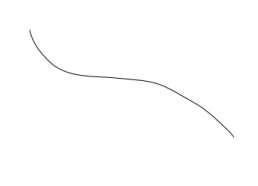

In [5]:
im

## Ajout du mapping des points:

In [6]:
# Initialisation of potential function matrix and starting point

# Potential
W = im_array
n = im_array.shape[0]
# Mapping
mapping = {}
# Starting set
S = [(33, 40)]

lmbda = 10
eps =  0.15*lmbda

dumb_stopping = 0

rec_l2 = []

i = 0
while True:
    fm = FastMarching(W**5, S, mapping)
    
    while not fm.stopping_crit_lambda(lmbda):
        fm.forward()
    keypoint = fm.stopping_crit_lambda(lmbda)
    fm.set_origin(keypoint)
    S.append(keypoint)
    
    print('Iter: {} | Found keypoint:{}'.format(i, keypoint))
    
    if i == 0:
        fm.mapping[S[0]] = S[1]
        
    origin = fm.mapping[keypoint]
    prior_origin = fm.mapping[origin]

    l2_prior_keypoint = np.linalg.norm(np.array(keypoint) - np.array(prior_origin), 2)
    rec_l2.append(l2_prior_keypoint)
    
    print('Prior to keypoint, L2', l2_prior_keypoint)
    
    mapping = fm.mapping
    
    
    if i != 0 and abs(l2_prior_keypoint-2*lmbda) >= eps:
        dumb_stopping += 1
    else:
        dumb_stopping = 0
    
    if dumb_stopping == 2:
        S.pop()
        S.pop()
        break
    
    i += 1

Iter: 0 | Found keypoint:(43, 41)
Prior to keypoint, L2 0.0
Iter: 1 | Found keypoint:(53, 42)
Prior to keypoint, L2 20.09975124224178
Iter: 2 | Found keypoint:(23, 38)
Prior to keypoint, L2 20.223748416156685
Iter: 3 | Found keypoint:(63, 45)
Prior to keypoint, L2 20.396078054371138
Iter: 4 | Found keypoint:(72, 51)
Prior to keypoint, L2 21.02379604162864
Iter: 5 | Found keypoint:(79, 59)
Prior to keypoint, L2 21.2602916254693
Iter: 6 | Found keypoint:(17, 29)
Prior to keypoint, L2 19.4164878389476
Iter: 7 | Found keypoint:(12, 20)
Prior to keypoint, L2 21.095023109728988
Iter: 8 | Found keypoint:(86, 67)
Prior to keypoint, L2 21.2602916254693
Iter: 9 | Found keypoint:(91, 76)
Prior to keypoint, L2 20.808652046684813
Iter: 10 | Found keypoint:(11, 10)
Prior to keypoint, L2 19.924858845171276
Iter: 11 | Found keypoint:(9, 30)
Prior to keypoint, L2 16.1245154965971
Iter: 12 | Found keypoint:(4, 18)
Prior to keypoint, L2 17.029386365926403


In [7]:
points_array = [list(i) for i in S]
points_array = np.array(points_array)

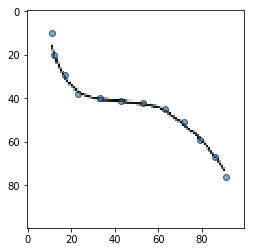

In [8]:
plt.imshow(fm.W, cmap='gray')
plt.scatter(points_array[:, 0], points_array[:, 1], edgecolor='k', alpha=0.6)
plt.show()

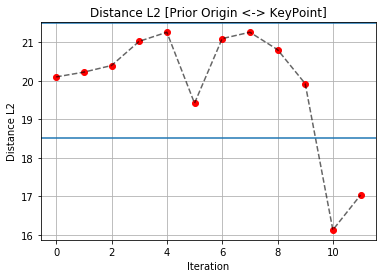

In [9]:
plt.figure()
plt.title('Distance L2 [Prior Origin <-> KeyPoint]')
plt.ylabel('Distance L2')
plt.xlabel('Iteration')
plt.plot(rec_l2[1:], 'ro')
plt.plot(rec_l2[1:], 'k--', alpha=0.6)

plt.axhline(2*lmbda - eps)
plt.axhline(2*lmbda + eps)

plt.grid()
plt.show()

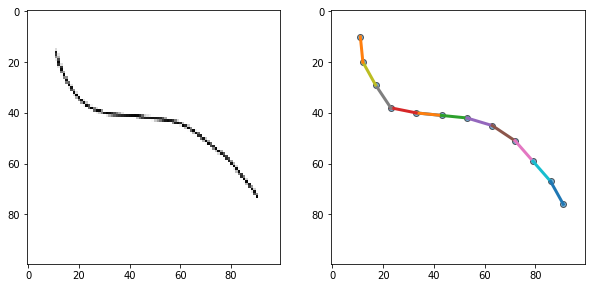

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(fm.W, cmap='gray', alpha=1)
plt.subplot(122)
plt.imshow(fm.W, cmap='gray', alpha=0)
for point in fm.Set:
    origin_point = fm.mapping[point]
    plt.plot([origin_point[0], point[0]], [origin_point[1], point[1]], linewidth=3)
    
points_array = [list(i) for i in fm.Set]
points_array = np.array(points_array)
plt.scatter(points_array[:, 0], points_array[:, 1], edgecolor='k', alpha=0.6)
plt.show()